# File Setup

In [2]:
import os
print(os.listdir())
directory_path = ''

#from google.colab import drive
#import sys
#drive.mount('/content/drive')
#directory_path = '/content/drive/MyDrive/Quantum/'
#sys.path.append('/content/drive/MyDrive/Quantum')
# print(os.listdir(directory_path))

['dense_small.param', '.DS_Store', 'quantum_experiments', 'DiscreteVariationalParameterizationsDeepV2.py', 'Mutual_Information_Transformer.ipynb', '__pycache__', 'DiscreteVariationalParameterizationsDeepV3.py', 'README.md', 'Mutual_Information_Maximizing_Model.ipynb', 'temp.txt', '.ipynb_checkpoints', '.git', 'QuantumSimulatorDataset.py', 'GibbsSampling.py', '.idea']


In [3]:
!pip install torch
!pip install qiskit-aer
!pip install qiskit
!pip install pylatexenc
!pip install tqdm
!pip install scikit-learn

In [4]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import ast
import torch.optim as optim
from sklearn.metrics import mutual_info_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from QuantumSimulatorDataset import QuantumSimulationDatasetFast, generate_circuit_params

# MI and Entropy

In [57]:
def entropy(X):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    
    # Count the occurrences of each unique value
    unique_vals, counts = X_flat.unique(return_counts=True)
    probabilities = counts.float() / counts.sum()
    entropy = -torch.sum(probabilities * torch.log(probabilities))
        
    return entropy.item()

def mutual_info_loss(X, Y):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    Y_flat = Y.view(-1)
    
    return -mutual_info_score(X_flat, Y_flat)

class MILoss(nn.Module):
    def __init__(self):
        super(MILoss, self).__init__()

    def forward(self, input, target):
        # Flatten the tensor to 1D
        X_flat = input.view(-1)
        Y_flat = target.view(-1)
    
        return -mutual_info_score(X_flat, Y_flat)


# Model Definition

In [58]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, heads):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.heads = heads
        # distribution of dimensionaltiy
        self.head_dim = d_model // heads

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, d_model) # concat all heads back into one

        # binary output
        self.sigmoid = nn.Sigmoid()

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        # computing attention scores
        energy = torch.einsum("nqhd,nkhd->nhqk", [query, keys])
        # masking
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-inf"))
        # attention weights
        attention = torch.softmax(energy / (self.d_model ** (1/2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        out = self.sigmoid(out) # output is within range 0, 1

        out_binary = (out >= 0.5).float()

        return out_binary

class TransformerBlock(nn.Module):
    def __init__(self, d_model, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        # attention block, normalization, feedforward, normalization again (mimicing GPT)
        self.attention = SelfAttention(d_model, heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, forward_expansion * d_model),
            nn.ReLU(),
            nn.Linear(forward_expansion * d_model, d_model),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # skip connection
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Encoder
class Encoder(nn.Module):
    def __init__(self, device, input_dim, d_model, heads, dropout, num_layers, forward_expansion):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.device = device
        self.num_tokens = 2 # binary

        self.embedding = nn.Embedding(self.num_tokens, d_model)
        self.position_embedding = nn.Embedding(input_dim, d_model)

        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, heads, dropout, forward_expansion)
            for _ in range(num_layers)]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        out = self.dropout(self.embedding(x) + self.position_embedding(positions))

        for layer in self.layers:
            out = layer(out, out, out, mask) # encoder has same keys, queries, and values

        #print('Encoder Out:', out.shape)

        return out

class DecoderBlock(nn.Module):
    def __init__(self, device, d_model, heads, dropout, forward_expansion):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(d_model, heads)
        self.norm = nn.LayerNorm(d_model)
        self.transformer_block = TransformerBlock(d_model, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, tgt_mask):
        attention = self.attention(x, x, x, tgt_mask)
        query = self.dropout(self.norm(attention + x)) # skip connection
        out = self.transformer_block(value, key, query, src_mask)
        return out

class Decoder(nn.Module):
    def __init__(self, device, output_dim, d_model, heads, dropout, num_layers, forward_expansion):
        super(Decoder, self).__init__()
        self.num_tokens = 2 # binary
        self.device = device
        self.word_embedding = nn.Embedding(self.num_tokens, d_model)
        self.position_embedding = nn.Embedding(output_dim, d_model)

        self.layers = nn.ModuleList(
            [DecoderBlock(device, d_model, heads, dropout, forward_expansion)
             for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(d_model, output_dim)
        self.dropout = nn.Dropout(dropout)
        # binary output
        self.sigmoid = nn.Sigmoid()

    # x is input into decoder
    def forward(self, x, enc_out, src_mask, tgt_mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, tgt_mask)

        out = self.fc_out(x)
        out = self.sigmoid(out)  # Output is now within range 0, 1
        out_binary = (out >= 0.5).float()  # Convert to binary if needed

        mode_tensor, _ = out_binary.mode(dim=1)
        # Flatten the mode_tensor to get a single tensor of 12 elements
        flattened_mode_tensor = mode_tensor.view(out_binary.size(0), out_binary.size(2))

        return flattened_mode_tensor

class QuantumTransformer(nn.Module):
    def __init__(self, src_pad_idx, tgt_pad_idx, d_model, heads, dropout, forward_expansion, num_layers, input_dim, output_dim,):
        super(QuantumTransformer, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.encoder = Encoder(self.device, input_dim, d_model, heads, dropout, num_layers, forward_expansion)
        self.decoder = Decoder(self.device, output_dim, d_model, heads, dropout, num_layers, forward_expansion)

        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # source mask is N,1,1,src_len
        return src_mask.to(self.device)

    def make_tgt_mask(self, tgt):
        N, tgt_len = tgt.shape
        # triangular matrix (not raw attention weights)
        tgt_mask = torch.tril(torch.ones((tgt_len, tgt_len))).expand(
            N, 1, tgt_len, tgt_len
        )
        return tgt_mask.to(self.device)

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(tgt, enc_src, src_mask, tgt_mask)
        return out

# Model Initialization and Training

In [59]:
#Version 1
src_pad_idx = 0
tgt_pad_idx = 0
d_model = 256
heads = 4
dropout = 0.1
forward_expansion = 4
num_layers = 6
input_dim = 12
output_dim = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuantumTransformer(src_pad_idx, tgt_pad_idx, d_model, heads, dropout, forward_expansion, num_layers, input_dim, output_dim)
model = model.to(device)
print('Device:', device)

Device: cpu


In [61]:
criterion = nn.BCELoss()
# criterion = mutual_info_loss()
optimizer = optim.Adam(model.parameters(), lr=10)

num_iterations = 1000
batch_size = 128

params = generate_circuit_params(0,12)
#params = generate_circuit_params(file_name = directory_path + 'dense_small.param')
dataset = QuantumSimulationDatasetFast(params, batch_size, 4, device, inverse_density=3)

BCElosses = []
MI = []

In [64]:
print('Training')
for idx, (initial_state, final_state) in enumerate(dataset):
    optimizer.zero_grad()
    final_state.requires_grad = True
    
    out = model(initial_state.long(), final_state.long())
    loss = criterion(out, final_state.float())
    mutual_info = mutual_info_score(initial_state.view(-1), out.view(-1))
    expected_mutual_info = mutual_info_score(initial_state.view(-1), final_state.detach().view(-1))
    initial_entropy = entropy(initial_state)
            
    # Backward pass and optimization
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    BCElosses.append(loss.detach().item())
    MI.append(mutual_info)

    if idx % 10 == 0:
        print('| Iteration', idx, ' > BCEloss(Y,ȳ):', f"{loss:,.5f}", 
              ' I(X,ȳ):', f"{mutual_info:,.5f}",
              ' I(X,Y):', f"{expected_mutual_info:,.5f}",
              ' H(X):', f"{initial_entropy:,.5f}")

    if idx > num_iterations:
        print('Training Terminated')
        break

Training
tensor([0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.]) tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       grad_fn=<SelectBackward0>)
| Iteration 0  > BCEloss(Y,ȳ): 47.85156  I(X,ȳ): 0.00055  I(X,Y): 0.63651  H(X): 0.63651
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]) tensor([1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)
tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.]) tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.],
       grad_fn=<SelectBackward0>)
tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.]) tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       grad_fn=<SelectBackward0>)
tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.]) tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)
tensor([0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
       grad_fn=<SelectBackward0>)
tensor([0., 1.

KeyboardInterrupt: 

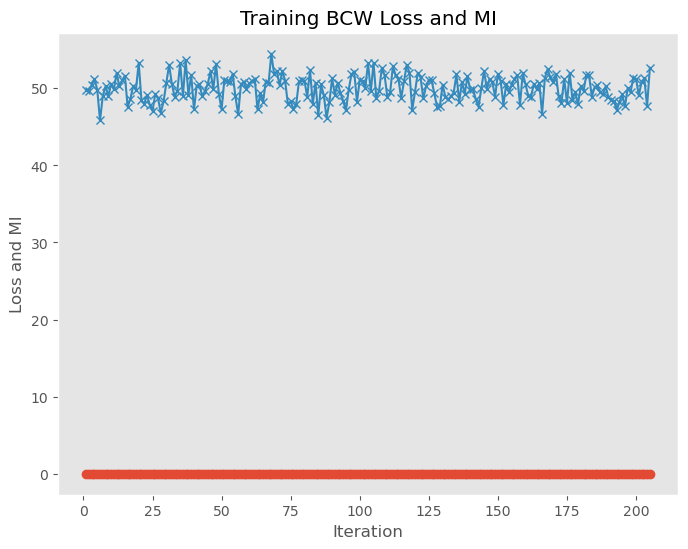

In [63]:
BCEloss_np = np.array(BCElosses)
MI_np = np.array(MI)

plt.style.use('ggplot')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(MI_np)+1), MI_np, marker='o')
plt.plot(range(1, len(BCEloss_np)+1), BCEloss_np, marker='x')

plt.title('Training BCW Loss and MI')
plt.xlabel('Iteration')
plt.ylabel('Loss and MI')
plt.grid()
plt.show()

In [ ]:
# Testing loop
model.eval()
total_loss = 0.0
predictions = []
given = []
actual = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs}')):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs.long(), targets.long())
        loss = criterion(outputs, targets.float())
        total_loss += loss.item()

        for i in range(len(inputs)):
            predictions.append(outputs[i].tolist())
            given.append(inputs[i].tolist())
            actual.append(targets[i].tolist())

    avg_test_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

# Save the model and predictions
torch.save(model.state_dict(), 'quantum_transformer_model.pth')
preds = {
    'Initial_States': given,
    'Final_State_Pred': predictions,
    'Final_States': actual
}
final_df = pd.DataFrame(preds)
final_df.head()